

# Scalable Retrieval with Project Gutenberg

Modern AI systems don’t just generate answers — they rely on **retrieval** to find the right context before generation. Whether you’re building a search engine, a recommendation system, or a Retrieval-Augmented Generation (RAG) pipeline, the quality and speed of retrieval often determine how useful the final system will be.

we explore the core ideas of **scalable** retrieval using Project Gutenberg texts. Books are long, hierarchical, and varied — which makes them an excellent testbed for learning how to index, search, and evaluate retrieval aton, or just keep it high-level so the reranker is an assignment step?
tudents can *see* the difference between the two structures?
letions spelled out as mini-exercises)?


## 📚 The Project Gutenberg Corpus

we will be working with texts from **Project Gutenberg**, a large collection of public-domain books. Project Gutenberg has been digitizing and distributing literary works since 1971, making it one of the oldest and largest open digital libraries. The collection spans over **70,000 works**, ranging from classic literature to historical documents.

Because the raw Project Gutenberg site can be tricky to scrape (inconsistent file formats, encodings, and compression), we’ll use a cleaned dataset hosted on Kaggle:

👉 [Project Gutenberg – Over 70,000 Books (Kaggle Dataset)](https://www.kaggle.com/datasets/jasonheesanglee/gutenberg-over-70000)

This version provides a consolidated, reproducible collection of the corpus, which avoids many of the Unicode and file format errors students encounter when downloading directly from gutenberg.org.

We’ll use this dataset as our **source corpus** for chunking, embedding, and retrieval experiments.



## Part 1: Download and Inspect the Data

1. **Download the dataset**

   * Use the Kaggle link above: [Project Gutenberg – Over 70,000 Books](https://www.kaggle.com/datasets/jasonheesanglee/gutenberg-over-70000).
   * Unzip the dataset into a directory on your computer. You should see:

     * Many book files in `.pkl` format (each file contains the text of a book).
     * A metadata file called `gutenberg_over_70000_metadata.csv`.

2. **Inspect the book files and metadata**

   * Scripts are provided to walk through the directory and preview the contents of `.pkl` files (e.g., first 100 characters or tokens).
   * The metadata file contains details such as book ID, title, and author.
   * Run them and look around a bit.

3. **Load the data**
   * You will extend these inspection scripts to combine the book text and metadata into a single data structure:

     * **Key:** book number (ID)
     * **Value:** dictionary with both the text and metadata details.
    **You may not want to load all the data at once, as that is very memory intensive. Just have a natural break point at, say, 1000 books, which you can remove later once we decide to modify this function to be more efficient.**



In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/archive_embeddings.zip" -d "/content"


In [5]:
import os
import pickle
import pandas as pd

def load_metadata(root_dir):
    filepath = os.path.join(root_dir, 'gutenberg_over_70000_metadata.csv')
    try:
        df = pd.read_csv(filepath)

        print("\nFilepath:", filepath)
        print(df.head(10))          # Show first 10 rows
        print("Total rows:", len(df))

    except Exception as e:
        print(f"Error opening {filepath}: {e}")
    return df

def preview_pkl_files(root_dir):
    """
    Traverse root_dir and subdirectories, open .pkl files,
    and print a preview of the first 100 characters or words.
    """
    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(".pkl"):
                filepath = os.path.join(subdir, file)
                try:
                    with open(filepath, "rb") as f:
                        data = pickle.load(f)

                    print('\n',filepath, data[:10],len(data))

                except Exception as e:
                    print(f"Error opening {filepath}: {e}")

In [6]:
loaded_metadata = load_metadata('archive')


Filepath: archive/gutenberg_over_70000_metadata.csv
   Unnamed: 0  Book Num                                         Book Title  \
0           0         1  The Declaration of Independence of the United ...   
1           1         2  The United States Bill of Rights by United States   
2           2         3  John F. Kennedy's Inaugural Address by John F....   
3           3         4    Lincoln's Gettysburg Address by Abraham Lincoln   
4           4         5    The United States Constitution by United States   
5           5         6  Give Me Liberty or Give Me Death by Patrick Henry   
6           6         7                              The Mayflower Compact   
7           7         8  Abraham Lincoln's Second Inaugural Address by ...   
8           8         9  Abraham Lincoln's First Inaugural Address by A...   
9           9        10                The King James Version of the Bible   

  Language                              Author Original Publication Date  \
0  English  

In [ ]:
preview_pkl_files("archive")


 archive/1-500/100_TheCompleteWorks.pkl ﻿The Proje 5575084

 archive/1-500/105_Persuasion.pkl ﻿The Proje 492795

 archive/1-500/101_TheHackerCrackdown.pkl ﻿The Proje 676766

 archive/1-500/103_AroundtheWorld.pkl ﻿The Proje 396802

 archive/1-500/109_RenascenceandOther.pkl ﻿The Proje 59197

 archive/1-500/111_Freckles.pkl ﻿The Proje 471964

 archive/1-500/10_TheKingJames.pkl ﻿The Proje 4451863

 archive/1-500/107_Farfromthe.pkl ﻿The Proje 809401

 archive/1-500/110_Tessofthe.pkl ﻿The Proje 878178

 archive/1-500/108_TheReturnof.pkl ﻿The Proje 706789

 archive/1-500/113_TheSecretGarden.pkl ﻿The Proje 457765

 archive/1-500/112_Violists.pkl ﻿The Proje 140443

 archive/1-500/115_UnitedStatesCensus.pkl ﻿The Proje 2065996

 archive/1-500/102_TheTragedyof.pkl ﻿The Proje 320449

 archive/1-500/106_JungleTalesof.pkl ﻿The Proje 440694

 archive/1-500/104_InauguralAddressof.pkl ﻿The Proje 31230

 archive/1-500/134_MariaOrThe.pkl ﻿The Proje 283172

 archive/1-500/131_ThePilgrimsProgress.pkl ﻿The 

KeyboardInterrupt: 



## 📖 From Text to Embeddings

Note that actually loading the raw text of all the books is extremely cumbersome, and also not that useful for retrieval. Instead, for retrieval systems, we don’t search directly over words — we search in **embedding space**, where each passage of text is represented as a dense vector.

Why do we need **chunking**?

* Embedding models have a **fixed input size** (typically 512–1024 tokens). A whole book is far too long to fit.
* Even if a model could process the entire book, a single embedding would dilute meaning — specific details would get lost.
* By splitting the book into smaller, overlapping passages (e.g. 500 words with 50 words overlap), we keep each chunk semantically coherent and within the model’s capacity.

Why do we need **aggregation**?

* If we only keep passage-level embeddings, retrieval becomes more expensive (millions of vectors).
* Sometimes we want a **compact representation** of the entire book (for catalog search, or as a coarse filter before drilling down).
* Aggregating embeddings — for example by **averaging** all chunk embeddings — provides this compact representation while still reflecting the book’s overall content.
* Averaging is a simple and widely used method: it balances the contributions of all chunks without blowing up dimensionality. Other methods (max pooling, weighted averaging, multi-vector representations) exist, but averaging is the most practical starting point.

---
--

Since entire books are far too long to embed directly, we need to:

1. **Chunk** the book into smaller passages (e.g. \~500 words each, with overlap).
2. **Embed** each passage using a pretrained model.
3. **Aggregate** the embeddings into a single book-level vector (e.g. by averaging).

Computing embeddings for all chunks can be expensive. To make this feasible, we will **subsample** by taking only the first *N* chunks (e.g. $N=1$) per book. This reduces memory and runtime while still giving a representative eme students?



### Your Task

* First, look over the two functions offered to you below. You can use them, modify them, or rewrite your own functions. If you use these ones, please fill out the prompts in the comments, as you could be asked about it later.
* Next, modify your loading function from above to load the embedding computed from the text, rather than the entire text itself. You should notice that memory does not grow nearly as large.

Once it is all loaded, you can save it in a pkl file, to be easily loaded in the future.

This step can take a while. You may not want to do it last minute.


In [12]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def chunk_text(text, chunk_size=500, overlap=50, max_num_chunks=10):
    """
    Splits input text into overlapping chunks of specified size.

    Args:
        text (str): Full book text.
        chunk_size (int): Number of words per chunk.
        overlap (int): Number of overlapping words between chunks.
        max_num_chunks (int): Max number of chunks per book.

    Returns:
        List[str]: List of text chunks.
    """
    words = text.split()
    chunks = []
    start = 0
    while start < len(words) and len(chunks) < max_num_chunks:
        end = min(start + chunk_size, len(words))
        chunk = " ".join(words[start:end])
        chunks.append(chunk)
        start += chunk_size - overlap
    return chunks

def embed_book(text, chunk_size=500, overlap=50, aggregate="mean"):
    """
    Chunks the text, embeds each chunk, and aggregates the embeddings.

    Args:
        text (str): Full book text.
        chunk_size (int): Size of each text chunk (in words).
        overlap (int): Overlap between chunks.
        aggregate (str): Aggregation method ("mean" or "max").

    Returns:
        np.ndarray: Aggregated embedding for the book.
    """
    chunks = chunk_text(text, chunk_size, overlap)
    embeddings = model.encode(chunks, convert_to_numpy=True)

    if aggregate == "mean":
        return np.mean(embeddings, axis=0)
    elif aggregate == "max":
        return np.max(embeddings, axis=0)
    else:
        raise ValueError("Unsupported aggregation method. Use 'mean' or 'max'.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
#Aggregation logic
import pickle
import numpy as np

# here we do chunking on every book, embed the chunks and agregate then to store under one pkl file per book
def process_books_and_store(books, chunk_size=500, overlap=50, max_num_chunks=10,
                            output_file="book_embeddings.pkl", embedding_dim=384):
    all_book_embeddings = {}

    for i, (book_id, book_data) in enumerate(books.items(), 1):
        text = book_data.get('text', "")
        metadata = book_data.get('metadata', {})

        # error handling
        if not text.strip():
            print(f"Warning: Book {book_id} has empty text. Skipping.")
            continue

        try:
            chunk_embs = embed_book(text, chunk_size=chunk_size, overlap=overlap)
        except Exception as e:
            print(f"Error embedding book {book_id}: {e}")
            chunk_embs = np.zeros((1, embedding_dim))

        # Handle empty embeddings
        if chunk_embs.size == 0:
            print(f"Warning: Book {book_id} produced no embeddings. Using zero vector.")
            chunk_embs = np.zeros((1, embedding_dim))

        # Aggregate to one book-level embedding
        book_emb = np.mean(chunk_embs, axis=0)

        all_book_embeddings[book_id] = {
            "embedding": book_emb,
            "metadata": metadata
        }

        if i % 50 == 0:
            print(f"Processed {i}/{len(books)} books")

    # Save as pickle file
    with open(output_file, "wb") as f:
        pickle.dump(all_book_embeddings, f)

    print(f"Saved embeddings for {len(all_book_embeddings)} books to {output_file}")
    return all_book_embeddings

In [8]:
import pandas as pd
import os

# for each book, based on the filename extracts data from the loaded csv.
def get_metadata_for_book(filename, metadata_df):
    try:
        book_num = int(filename.split("_")[0])
    except ValueError:
        print(f"Warning: Could not extract Book Num from {filename}")
        return {}

    row = metadata_df[metadata_df["Book Num"] == book_num]
    if row.empty:
        return {}

    return {
        "title": row["Book Title"].values[0],
        "author": row["Author"].values[0],
        "language": row["Language"].values[0],
        "original_pub_date": row["Original Publication Date"].values[0],
        "published_date": row["Published Date"].values[0]
    }


In [9]:
import os
import pickle

def process_archive_with_metadata(input_root="archive",
                                  output_root="archive_embeddings",
                                  metadata_csv_path="archive_gutenberg/gutenberg_over_70000_metadata.csv",
                                  chunk_size=500,
                                  overlap=50,
                                  max_num_chunks=10):
    os.makedirs(output_root, exist_ok=True)

    # Load metadata CSV
    metadata_df = pd.read_csv(metadata_csv_path)

    for subdir, _, files in os.walk(input_root):
        # Mirror folder structure inside output_root
        rel_path = os.path.relpath(subdir, input_root)
        out_dir = os.path.join(output_root, rel_path)
        os.makedirs(out_dir, exist_ok=True)

        for file in files:
            if not file.endswith(".pkl"):
                continue

            in_path = os.path.join(subdir, file)
            out_path = os.path.join(out_dir, file)  # same filename in output folder

            if os.path.exists(out_path):
                print(f"Skipping {in_path} (already processed)")
                continue

            print(f"Processing {in_path}...")

            # Load raw text
            with open(in_path, "rb") as f:
                raw_text = pickle.load(f)

            book_id = os.path.splitext(file)[0]

            # fetch the metadata for each book
            metadata = get_metadata_for_book(file, metadata_df)
            books_dict = {book_id: {"text": raw_text, "metadata": metadata}}

            # create embeddings dynamically and combine with metadata and store as pkl file.
            process_books_and_store(
                books_dict,
                chunk_size=chunk_size,
                overlap=overlap,
                max_num_chunks=max_num_chunks,
                output_file=out_path
            )

            print(f"Saved embeddings -> {out_path}")

In [ ]:
input_root = '/content/drive/MyDrive/archive_embeddings.zip'
output_root_base= "/content/archive_embeddings"


In [ ]:
import os


subfolders = sorted([
    f for f in os.listdir(input_root)
    if os.path.isdir(os.path.join(input_root, f)) and not f.startswith(".")
])

for subfolder in subfolders:
    input_folder = os.path.join(input_root, subfolder)
    output_folder = os.path.join(output_root_base, subfolder)

    # Debug: print folder paths
    print(f"\n--- Processing batch '{subfolder}' ---")
    print(f"Input folder: {input_folder}")
    print(f"Output folder: {output_folder}")

    # Call the embedding + metadata function
    process_archive_with_metadata(
        input_root=input_folder,
        output_root=output_folder,
        metadata_csv_path=os.path.join(input_root, "gutenberg_over_70000_metadata.csv"),
        chunk_size=500,
        overlap=50,
        max_num_chunks=10
    )

Streaming output truncated to the last 5000 lines.
Processing archive/23501-24000/23830_Leduelau.pkl...
Saved embeddings for 1 books to archive_embeddings/23501-24000/./23830_Leduelau.pkl
Saved embeddings -> archive_embeddings/23501-24000/./23830_Leduelau.pkl
Processing archive/23501-24000/23840_.pkl...
Saved embeddings for 1 books to archive_embeddings/23501-24000/./23840_.pkl
Saved embeddings -> archive_embeddings/23501-24000/./23840_.pkl
Processing archive/23501-24000/23853_RanAwayto.pkl...
Saved embeddings for 1 books to archive_embeddings/23501-24000/./23853_RanAwayto.pkl
Saved embeddings -> archive_embeddings/23501-24000/./23853_RanAwayto.pkl
Processing archive/23501-24000/23859_AVenetianJune.pkl...
Saved embeddings for 1 books to archive_embeddings/23501-24000/./23859_AVenetianJune.pkl
Saved embeddings -> archive_embeddings/23501-24000/./23859_AVenetianJune.pkl
Processing archive/23501-24000/23858_TheAmericanCredo.pkl...
Saved embeddings for 1 books to archive_embeddings/23501-2

In [ ]:
import os
import pickle

# here we combine all the different pkl files present in different folder, format it in {bookid:{metadata:{}, embedding:[]}} format and store it as a pkl file.
root_folder = '/content/archive_embeddings'
books = {}

for folder_path, _, files in os.walk(root_folder):

    # skip system folders like __MACOSX
    if '__MACOSX' in folder_path:
        continue

    for file_name in files:
        if file_name.endswith('.pkl'):
            try:
                file_path = os.path.join(folder_path, file_name)

                # book id is the value before the first underscore
                book_id = file_name.split('_')[0]

                # Load the pickle file
                with open(file_path, 'rb') as f:
                    data = pickle.load(f)

                # the first key is the bookTitle which we use to read data from the embedding.
                key = list(data.keys())[0]

                # Store in the dictionary
                books[book_id] = data[key]

                print(f"Loaded {file_name} as bookId {book_id}")

            except Exception as e:
                print(f"Error loading {folder_path}/{file_name}: {e}")

output_path = '/content/drive/MyDrive/books.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(books, f)

print(f"\n✅ Saved combined data to: {output_path}")


Streaming output truncated to the last 5000 lines.
Loaded 7803_TheStoryof.pkl as bookId 7803
Loaded 7641_ErnestMaltravers.pkl as bookId 7641
Loaded 7532_ABookof.pkl as bookId 7532
Loaded 7986_PlaysbyAnton.pkl as bookId 7986
Loaded 7902_AmericanHistoricaland.pkl as bookId 7902
Loaded 7829_AmericanPrisonersof.pkl as bookId 7829
Loaded 7774_TheJournalof.pkl as bookId 7774
Loaded 7646_ErnestMaltravers.pkl as bookId 7646
Loaded 7635_TheDisowned.pkl as bookId 7635
Loaded 7684_Haroldthe.pkl as bookId 7684
Loaded 7954_TwentyFiveVillageSermons.pkl as bookId 7954
Loaded 7867_CrookedTrails.pkl as bookId 7867
Loaded 7756_GodolphinComplete.pkl as bookId 7756
Loaded 7905_AmericanHistoricaland.pkl as bookId 7905
Loaded 7876_Passagesfromthe.pkl as bookId 7876
Loaded 7907_AmericanHistoricaland.pkl as bookId 7907
Loaded 7690_LucretiaVolume.pkl as bookId 7690
Loaded 7703_MyNovel.pkl as bookId 7703
Loaded 7633_TheDisowned.pkl as bookId 7633
Loaded 7985_ZurfreundlichenErinnerung.pkl as bookId 7985
Loaded 7

In [ ]:
books ={}
import pickle

with open('/content/drive/MyDrive/books.pkl', 'rb') as f:
    books = pickle.load(f)

In [2]:
books['1']['metadata']

{'title': 'The Declaration of Independence of the United States of America by Thomas Jefferson',
 'author': 'Jefferson, Thomas',
 'language': 'English',
 'original_pub_date': '-',
 'published_date': 'Dec 1, 1971'}

## Part 1 – Step 1: Build a Flat k-NN Graph

1. **Pairwise Distances**

   * In your notebook, write out the underlying equations for this computation.
   * Comment on the computational and memory complexity of this approach (it is $O(m^2)$ in both time and space, where $m$ is the number of books).
   * Make sure you understand the math — don’t just memorize it. I may ask you to reproduce it.

2. **Visualization with PCA**

   * Use PCA to reduce the embeddings to 2D, and plot the books in this space.
   * Instead of labeling points with IDs, annotate them with their book titles from the metadata. For example:

     ```python
     plt.text(embedding_2d[i, 0], embedding_2d[i, 1], book_embs[label]['metadata']['Book Title'], fontsize=6, alpha=0.7)
     ```
   * Comment on the geometry and clustering of these visual embeddings. Do they make sense?

3. **Nearest Neighbor Graph**

   * Create a nearest neighbor graph using `networkx`.
   * Each node corresponds to a book embedding.
   * You may connect nodes in one of two ways:

     * **Fixed degree (k-NN):** Connect each node to its $d$ closest neighbors, where $d$ is a hyperparameter (e.g. 5, 10, 20).
     * **Distance threshold:** Connect each node to any other node whose distance is less than a threshold $\varepsilon$, for example the 15th percentile of all pairwise distances.
   * Instead of plotting the raw graph with all its edges (which quickly becomes unreadable), visualize the graph structure using its adjacency matrix.

4. **Discussion**

   * Comment on the pros and cons of constructing an NN graph in each of the two ways.
   * How sensitive is the graph structure to the choice of $d$ or $\varepsilon$?
   * Compare how graph connectivity changes with the hyperparameter (clusters vs. isolated nodes).



In [14]:
subset = 5000

In [15]:
book_ids = sorted(books.keys())
embeddings =  np.array([books[b_id]['embedding'] for b_id in book_ids])

#performing for a subset of books.
# NOTE: I have run the code for 100 books, 1000 books and 5000 books. Due to limited compute power I was unable to do it for 70000 books (Issue with Google Colab Pro RAM)

sliced_book_ids = book_ids[:subset]
sliced_embeddings = np.array([books[b_id]['embedding'] for b_id in sliced_book_ids])
titles = [books[b_id]['metadata'].get('title', f'Book {b_id}') for b_id in sliced_book_ids]



In [16]:
len(embeddings)

70809

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
import networkx as nx
import seaborn as sns
from sklearn.metrics.pairwise import cosine_distances

In [18]:
# using library function to compute pairwise cosine distances
dist_matrix = cosine_distances(sliced_embeddings)

print(f"Distance matrix shape: {dist_matrix.shape}")

Distance matrix shape: (5000, 5000)


In [19]:
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(sliced_embeddings)

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20853 (\N{CJK UNIFIED IDEOGRAPH-5175}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27861 (\N{CJK UNIFIED IDEOGRAPH-6CD5}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21608 (\N{CJK UNIFIED IDEOGRAPH-5468}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 39616 (\N{CJK UNIFIED IDEOGRAPH-9AC0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31639 (\N{CJK UNIFIED IDEOGRAPH-7B97}) missing from font(s) DejaVu Sans.
  fig.canvas

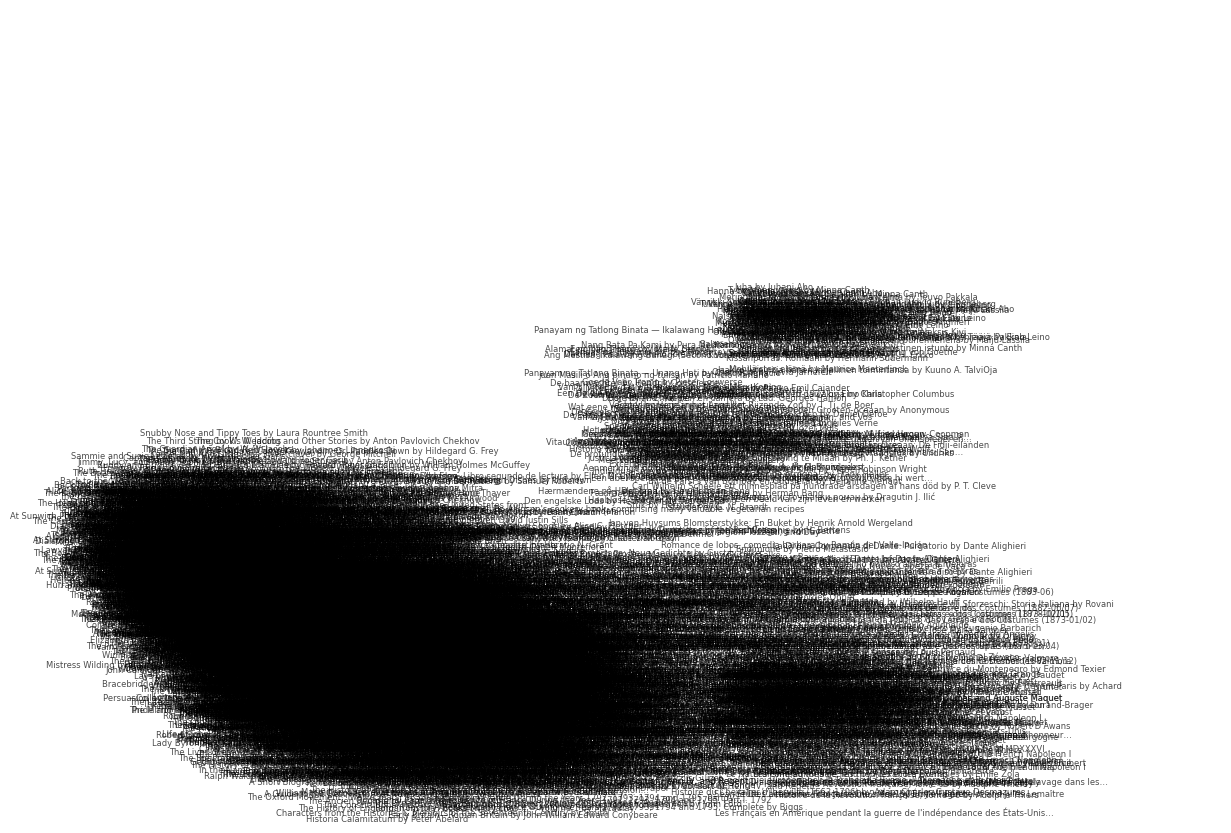

In [20]:
# view all the nodes.
plt.figure(figsize=(12, 8))
for i, book_id in enumerate(sliced_book_ids):
    title = books[book_id]['metadata'].get('title', f'Book {book_id}')
    plt.text(embedding_2d[i, 0], embedding_2d[i, 1], title, fontsize=6, alpha=0.7)

plt.axis('off')
plt.grid(True)

plt.show()

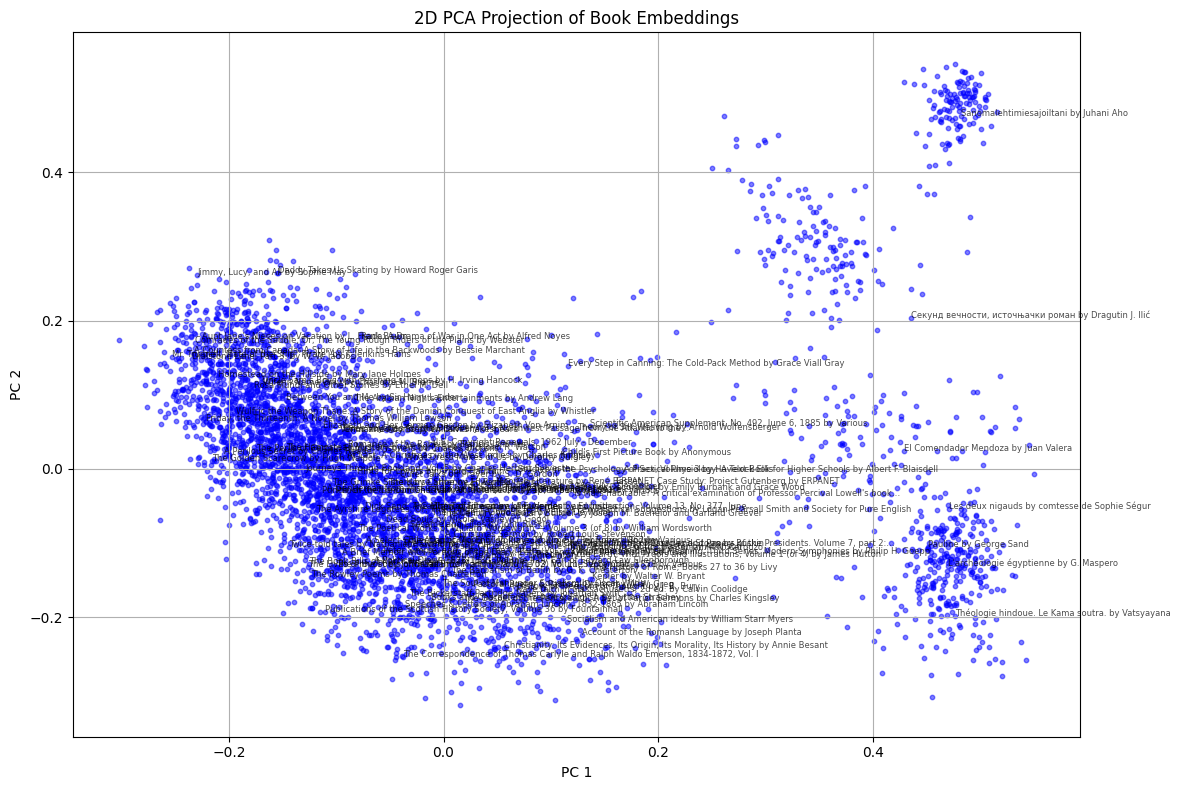

In [22]:
import matplotlib.pyplot as plt
import random

# here we only annotate a max of 100 labels to view the graph and sturcture properly.
max_labels = 100  # number of labels to annotate
sample_indices = random.sample(range(len(sliced_book_ids)), min(max_labels, len(sliced_book_ids)))


plt.figure(figsize=(12, 8))
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], alpha=0.5, s=10, c='blue')

for i in sample_indices:
    book_id = sliced_book_ids[i]
    title = books[book_id]['metadata'].get('title', f'Book {book_id}')
    x, y = embedding_2d[i]
    plt.annotate(title, (x, y), fontsize=6, alpha=0.7)

plt.title("2D PCA Projection of Book Embeddings")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
# Nearest Neighbor Graph (fixed degree k-NN, e.g., k=5)
k = 5
G_knn = nx.Graph()

for i in range(len(sliced_book_ids)):
    G_knn.add_node(i, label=sliced_book_ids[i])

    # Get k nearest neighbors (excluding self)
    nearest_indices = np.argsort(dist_matrix[i])[1:k+1]
    for j in nearest_indices:
        G_knn.add_edge(i, j, weight=dist_matrix[i][j])

In [24]:
# Alternative: Distance threshold (15th percentile)
threshold = np.percentile(dist_matrix, 15)
G_thresh = nx.Graph()

for i in range(len(sliced_book_ids)):
    G_thresh.add_node(i, label=sliced_book_ids[i])
    for j in range(len(sliced_book_ids)):
        if i != j and dist_matrix[i][j] < threshold:
            G_thresh.add_edge(i, j, weight=dist_matrix[i][j])

In [25]:
def plot_adjacency_matrix(G, title):
    adj = nx.to_numpy_array(G)
    plt.figure(figsize=(8, 6))
    sns.heatmap(adj, cmap='viridis', cbar=True)
    plt.title(title)
    plt.xlabel("Node Index")
    plt.ylabel("Node Index")
    plt.show()

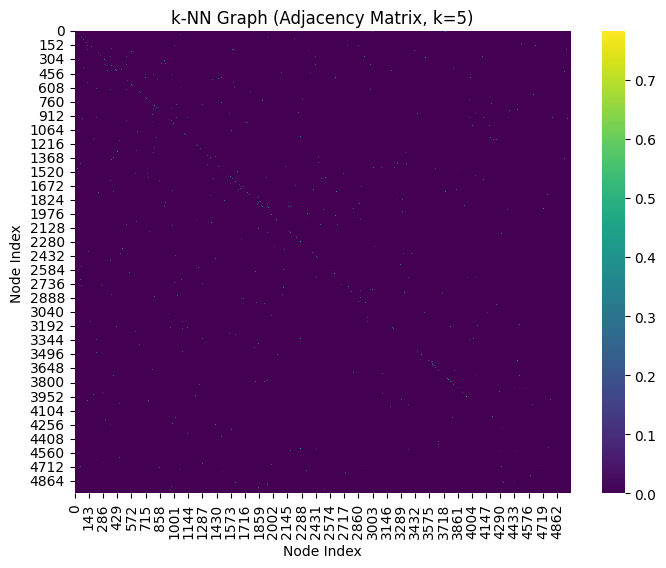

In [26]:
plot_adjacency_matrix(G_knn, "k-NN Graph (Adjacency Matrix, k=5)")

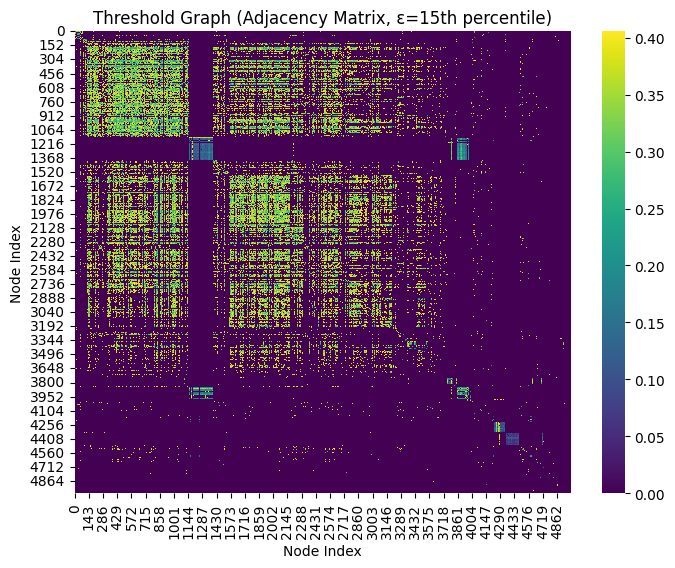

In [27]:
plot_adjacency_matrix(G_thresh, "Threshold Graph (Adjacency Matrix, ε=15th percentile)")

## Part 1 Step 2. **Perform NN search over the graph**

1. Given a **query vector**, traverse the graph to find the nearest neighbors.  

2. First, perform **exact search**:  
   * Embed the query.  
   * Compute squared distances to all book embeddings.  
   * Find and print the 5 nearest neighbors.  
   * Use Google (or another source) to verify whether these books are actually related to your query summary.  

3. Next, try an **approximate search** using *NN descent*:  
   * Start from a random node.  
   * Look for the neighbor that is closest to the query node.  
   * Keep moving until you can’t find a closer neighbor.  
   * Return the path of visited nodes and the final result.  

4. **Discussion:**  
   * What is the computational complexity of finding the exact *d* neighbors for each query?  
   * How could approximate nearest neighbors reduce this complexity?  
   * What problems can occur with approximate NN (e.g., local optima)?  
   * How could we bypass these problems (e.g., by using more than one random seed)?  

5. **Visualization (optional):** Plot the query and its connected neighbors on your PCA projection of the embeddings.

```

# --- Query text ---
query = """In a near-future world where borders constantly shift due to climate change
and political unrest, a young cartographer named Elara is recruited by an international
coalition to create the first “living map” — a dynamic atlas that redraws itself in real time.
As she works, she discovers that the map doesn’t just reflect the world, but begins to shape it:
cities vanish from memory, coastlines retreat overnight, and entire communities are erased when
they no longer appear on her charts. Torn between her duty to her employers and her conscience,
Elara sets out on a journey across collapsing nations to uncover who is really controlling the
map — and whether she can break the paradox before the world is redrawn beyond recognition."""

```



In [28]:
import numpy as np
import random
import time, tracemalloc




def profile(fn, fn_name, *args, **kwargs):
    print('profile',fn_name)
    tracemalloc.start()
    t0 = time.perf_counter()
    result = fn(*args, **kwargs)   # run the function
    t1 = time.perf_counter()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    print(f"{fn_name} took {t1 - t0:.4f}s, memory peak {peak/1e6:.2f} MB")
    return result


In [29]:
from sklearn.metrics.pairwise import euclidean_distances
import heapq

def exact_nn_search(query_text, books, embed_book, top_k=5):
    query_emb = embed_book(query_text)
    book_ids = list(books.keys())
    book_embs = np.array([books[bid]['embedding'] for bid in book_ids])

    # here we compute the euclidian distance.
    dists = np.sum((book_embs - query_emb) ** 2, axis=1)

    # sort them in asc order and fidning the top K ones.
    nearest_indices = np.argsort(dists)[:top_k]
    results = []
    for i in nearest_indices:
        bid = book_ids[i]
        title = books[bid]['metadata'].get('title', f'Book {bid}')
        results.append((bid, title, dists[i]))

    return results

In [30]:
query = """In a near-future world where borders constantly shift due to climate change
and political unrest, a young cartographer named Elara is recruited by an international
coalition to create the first “living map” — a dynamic atlas that redraws itself in real time.
As she works, she discovers that the map doesn’t just reflect the world, but begins to shape it:
cities vanish from memory, coastlines retreat overnight, and entire communities are erased when
they no longer appear on her charts. Torn between her duty to her employers and her conscience,
Elara sets out on a journey across collapsing nations to uncover who is really controlling the
map — and whether she can break the paradox before the world is redrawn beyond recognition."""

results = profile(exact_nn_search, "Exact NN Search", query, books, embed_book, top_k=5)

print("\nTop 5 Exact Nearest Neighbors:")
for bid, title, dist in results:
    print(f"Book ID: {bid}, Title: {title}, Distance: {dist:.4f}")


profile Exact NN Search
Exact NN Search took 0.9134s, memory peak 218.43 MB

Top 5 Exact Nearest Neighbors:
Book ID: 49711, Title: The National Geographic Magazine, Vol. I., No. 1, October, 1888 by Various, Distance: 0.7642
Book ID: 42638, Title: Encyclopaedia Britannica, 11th Edition, "Map" to "Mars" by Various, Distance: 0.7819
Book ID: 44884, Title: The Geography of Strabo, Volume 1 (of 3) by Strabo, Distance: 0.7965
Book ID: 57971, Title: The Boston School Atlas, Embracing a Compendium of Geography by B. Franklin Edmands, Distance: 0.8079
Book ID: 12107, Title: The Atlantic Monthly, Volume 09, No. 55, May, 1862 by Various, Distance: 0.8132


In [31]:
import networkx as nx
import random

def nn_descent(query_text, books, embed_book, G, max_steps=50):
    query_emb = embed_book(query_text)

    # here we select a random starting point from the nodeList
    current = random.choice(list(G.nodes))
    path = [current]

    def dist_to_query(node_idx):
        book_id = list(books.keys())[node_idx]
        return np.sum((books[book_id]['embedding'] - query_emb) ** 2)

    current_dist = dist_to_query(current)

    for step in range(max_steps):
        neighbors = list(G.neighbors(current))
        if not neighbors:
            break

        # find the nearest neighbor to the query.
        closest = min(neighbors, key=dist_to_query)
        closest_dist = dist_to_query(closest)

        if closest_dist < current_dist:
            current = closest
            current_dist = closest_dist
            path.append(current)
        else:
            break

    final_book_id = list(books.keys())[current]
    final_title = books[final_book_id]['metadata'].get('title', f'Book {final_book_id}')
    return path, final_book_id, final_title, current_dist


In [32]:
path, final_bid, final_title, final_dist = profile(nn_descent, "NN Descent", query, books, embed_book, G_knn)

print(f"\nApproximate NN Descent Result:")
print(f"Final Book ID: {final_bid}")
print(f"Title: {final_title}")
print(f"Distance to query: {final_dist:.4f}")
print(f"Visited path: {path}")


profile NN Descent
NN Descent took 0.1611s, memory peak 0.58 MB

Approximate NN Descent Result:
Final Book ID: 27503
Title: On the Equator by Harry De Windt
Distance to query: 1.0437
Visited path: [np.int64(4949), np.int64(1298), np.int64(544), 305]


### Discussion

**Exact NN Search Complexity:**
- Time: \(O(m \cdot d)\) — for computing distance to all \(m\) book embeddings.
- Space: \(O(m)\) — to store distances.

**Approximate NN Search via Graph Traversal:**
- Reduces time to roughly \(O(k \cdot \text{depth})\), where \(k\) is average node degree.
- Avoids full distance matrix computation.

**Limitations:**
- May get stuck in a **local optimum** (nearest neighbor among neighbors, but not globally).
- Result can vary based on the **starting node**.

**Improvements:**
- Use **multiple random restarts** and take the best result.
- Maintain a small **priority queue** of best candidates (like HNSW).


In [33]:
def plot_query_and_neighbors(query_emb, books, embedding_2d, book_ids, neighbors_ids):
    # reduce the dimensions
    pca = PCA(n_components=2)
    all_embs = np.array([books[bid]['embedding'] for bid in book_ids])
    all_2d = pca.fit_transform(np.vstack([all_embs, query_emb]))
    query_2d = all_2d[-1]
    book_2d = all_2d[:-1]

    plt.figure(figsize=(10, 8))
    plt.scatter(book_2d[:, 0], book_2d[:, 1], s=10, alpha=0.3)

    # Plot neighbors
    for nb in neighbors_ids:
        idx = book_ids.index(nb)
        title = books[nb]['metadata'].get('Book Title', str(nb))
        plt.scatter(book_2d[idx, 0], book_2d[idx, 1], c='orange', s=60, label="Neighbor")
        plt.text(book_2d[idx, 0], book_2d[idx, 1], title, fontsize=6)

    # Plot query
    plt.scatter(query_2d[0], query_2d[1], c='red', s=100, label="Query", marker='X')
    plt.title("Query and Nearest Neighbors in PCA Space")
    plt.legend()
    plt.grid(True)
    plt.show()


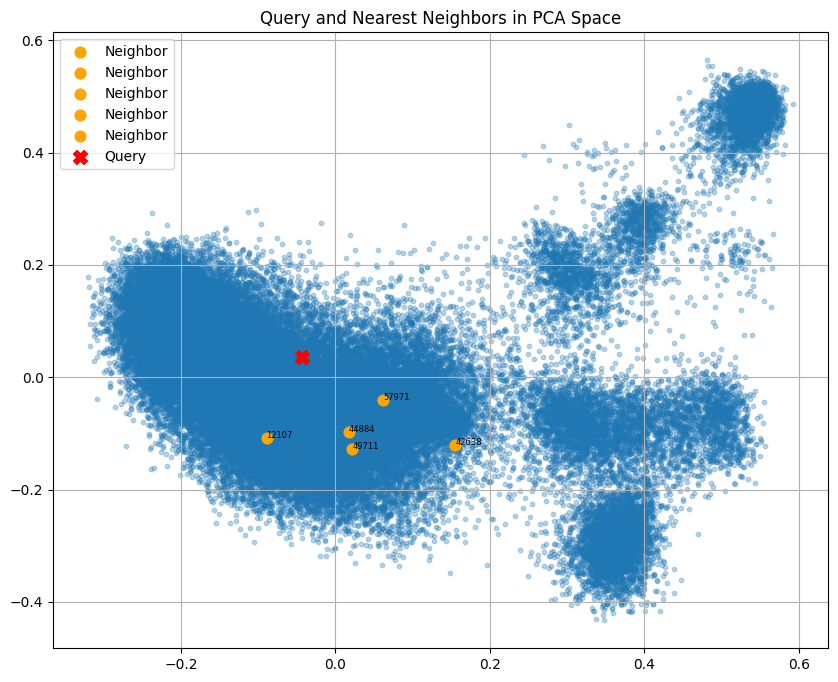

In [34]:
query_emb = embed_book(query)
neighbors = [res[0] for res in results]  # top-5 exact NN
plot_query_and_neighbors(query_emb, books, embedding_2d, book_ids, neighbors)


## Part 1 Step 3. **Add and Delete Nodes Online**

In real systems, data is not static — new documents (or books) arrive, and old ones may be removed. A good retrieval system must be able to **update its index online** without rebuilding everything from scratch.  

1. **Exact insertion and deletion**  
   * Insert a new node by computing its distance to **all existing nodes**.  
     - Find its nearest neighbors (e.g. top-k or within an ε-threshold).  
     - Connect it to those neighbors in the graph.  
   * Delete a node by removing it and repairing its neighbors.  
     - If nodes lose important edges (e.g. drop below degree k), recompute distances among affected neighbors to re-establish the k-NN property.  
   * **Question:** What is the computational complexity of inserting or deleting nodes *exactly* in this way? How does this scale as the graph grows?  

2. **Approximate insertion and deletion**  
   * Instead of comparing against all nodes:  
     - Start from a random entry node.  
     - Traverse the graph greedily, moving to neighbors closer to the new node.  
     - Use the visited nodes as candidates for edges.  
   * For deletion, simply remove the node and its edges without full repair, letting future approximate traversals fill in missing connections.  
   * **Question:** Where do the computational reductions come from in this approximate version? What trade-offs are introduced (e.g. possible missed neighbors, local optima)?  

3. **Discussion**  
   * Why is online add/delete functionality important in real retrieval systems?  
   * Compare the costs of exact vs approximate methods. In what scenarios would exact updates be necessary, and when is approximation acceptable?  


In [35]:
import numpy as np
import networkx as nx
import random
from sklearn.metrics.pairwise import euclidean_distances

In [36]:
def exact_insert_node(new_book_id, new_embedding, new_metadata, books, G, k=5):
    books[new_book_id] = {
        'embedding': new_embedding,
        'metadata': new_metadata
    }

    other_ids = list(books.keys())
    other_ids.remove(new_book_id)
    other_embs = np.array([books[i]['embedding'] for i in other_ids])
    dists = np.sum((other_embs - new_embedding) ** 2, axis=1)

    top_k_indices = np.argsort(dists)[:k]
    neighbors = [other_ids[i] for i in top_k_indices]

    G.add_node(str(new_book_id))
    for nid in neighbors:
        dist_val = np.sum((books[nid]['embedding'] - new_embedding) ** 2)
        G.add_edge(str(new_book_id), str(nid), weight=dist_val)


In [37]:
def exact_delete_node(book_id, books, G, k=5):
    if book_id not in G:
        return

    neighbors = list(G.neighbors(book_id))
    G.remove_node(book_id)
    del books[book_id]

    # here we repair the graph as mentioned in the task to ensure neighbors remain connected
    for i in range(len(neighbors)):
        for j in range(i+1, len(neighbors)):
            a, b = neighbors[i], neighbors[j]
            if not G.has_edge(a, b):
                dist = np.sum((books[a]['embedding'] - books[b]['embedding']) ** 2)
                G.add_edge(a, b, weight=dist)

    # we optionally trim to k neighbors per node
    for nid in neighbors:
        neighbors_dists = [
            (other, G[nid][other]['weight'])
            for other in G.neighbors(nid)
        ]
        neighbors_dists.sort(key=lambda x: x[1])
        for extra in neighbors_dists[k:]:
            G.remove_edge(nid, extra[0])


In [38]:
def approximate_insert_node(new_book_id, new_embedding, new_metadata, books, G, k=5, start_node=None, max_steps=50):
    books[new_book_id] = {
        'embedding': new_embedding,
        'metadata': new_metadata
    }

    if start_node is None:
        start_node = random.choice(list(G.nodes))

    def dist(a, b):
        return np.sum((a - b) ** 2)

    current = start_node
    current_dist = dist(new_embedding, books[str(current)]['embedding'])
    visited = {current}

    for _ in range(max_steps):
        neighbors = list(G.neighbors(current))
        found_better = False
        for nb in neighbors:
            if nb in visited:
                continue
            nb_dist = dist(new_embedding, books[str(nb)]['embedding'])
            if nb_dist < current_dist:
                current = nb
                current_dist = nb_dist
                visited.add(nb)
                found_better = True
                break
        if not found_better:
            break

    candidates = list(visited)
    candidates.sort(key=lambda nid: dist(new_embedding, books[str(nid)]['embedding']))
    top_k = candidates[:k]

    G.add_node(str(new_book_id))  # add node as string because we hve maintained nodeIds as str and not Int
    for nid in top_k:
        G.add_edge(str(new_book_id), str(nid), weight=dist(new_embedding, books[str(nid)]['embedding']))


In [39]:
def approximate_delete_node(book_id, books, G):
    if book_id in G:
        G.remove_node(book_id)
    if book_id in books:
        del books[book_id]
    # no neighbor repair; assume future insertions will restore connectivity


In [40]:
# here we embed a new fake book
new_id = str(len(sliced_book_ids) + 1)
new_text = "A story about shifting borders and a magical map that reshapes reality."
new_emb = embed_book(new_text)
new_meta = {'Book Title': "The Shifting Map"}

# Exact insert
exact_insert_node(new_id, new_emb, new_meta, books, G_knn, k=5)

# Exact delete
exact_delete_node(new_id, books, G_knn)

# Approx insert
approximate_insert_node(new_id, new_emb, new_meta, books, G_knn, k=5)

# Approx delete
approximate_delete_node(new_id, books, G_knn)


1. Exact Insertion/Deletion Complexity

Insertion:

Must compare to all
𝑛
n nodes →
𝑂
(
𝑛
⋅
𝑑
)
O(n⋅d) time

Scales quadratically as graph grows — not scalable for large datasets.

Deletion:

Requires re-evaluating neighbors to preserve connectivity →
𝑂
(
𝑘
2
⋅
𝑑
)
O(k
2
⋅d) worst-case



2. Approximate Insertion/Deletion Complexity

Insertion:

Greedy walk avoids full scan →
𝑂
(
𝑘
⋅
𝑑
⋅
steps
)
O(k⋅d⋅steps)

Reduces cost by visiting a small subset of nodes

Deletion:

Just remove node and edges →
𝑂
(
𝑘
)
O(k)



3. Trade-offs
Missing edges are eventually fixed during future insertions.


| Aspect            | Exact                       | Approximate                          |
| ----------------- | --------------------------- | ------------------------------------ |
| Accuracy          | High                        | Lower (can miss better neighbors)    |
| Speed             | Slow                        | Fast                                 |
| Scalability       | Poor for large graphs       | Excellent                            |
| Maintenance       | Repairs edges post-deletion | Skips repair                         |
| Local Optima Risk | None                        | **Yes** (greedy walks may get stuck) |




4. When to Use Each

Use exact:

For offline systems where quality matters (e.g., final model build)

When graph correctness is critical (e.g., medical retrieval)

Use approximate:

In real-time systems needing fast updates (e.g., search engines)

When small accuracy trade-offs are acceptable

## Part 2: **Hierarchical graphs**


So far, we have built and experimented with a **flat nearest neighbor graph**.  
Now we will move to a more scalable structure: the **Hierarchical Navigable Small-World (HNSW) graph**.  

### 🔎 What is HNSW?
HNSW is a graph-based data structure for **approximate nearest neighbor (ANN) search**.  
It extends the idea of a flat k-NN graph into a **multi-level hierarchy**, inspired by skip lists:  
- Each element is assigned a *maximum layer* at random.  
- Higher layers are sparse (few nodes, long-range connections).  
- Lower layers are dense (many nodes, local connections).  
- Searching starts at the top, then proceeds down through the levels, refining at each stage.  

This combination of *random layering* and *graph connectivity* yields very efficient nearest neighbor search.



## Part 2 Step 1: Construction of the HNSW Graph
1. **Random Level Assignment**  
   * Each node is assigned a maximum level \( L \), sampled from an exponential distribution.  
   * Most nodes only appear at the lowest level, while a few appear in many levels (acting as "hubs").  

2. **Layered Graphs**  
   * For each level \( \ell \), connect nodes to their nearest neighbors (just like in the flat k-NN graph).  
   * Higher levels have fewer nodes, so connections there act like "express lanes."  
   * Lower levels are more detailed, ensuring accuracy.  

3. **Hierarchy**  
   * The result is a stack of graphs: top layers are sparse and global, bottom layers are dense and local.  



I have given you a backbone of an HNSW that includes the build function. Answer the following questions.

 - Which layers is the densist?
 - Which layer contains the entry point?
 - What does the method sample_level return for a node? What is m_L? at graph?  

In [41]:
import numpy as np
import networkx as nx

class HNSW:
    def __init__(self, max_m=5, m_L=1.0, seed=42):
        """
        Simplified HNSW-style graph for teaching.
        """
        self.max_m = max_m
        self.m_L = m_L
        self.rng = np.random.default_rng(seed)
        self.layers = []             # list of graphs, one per layer
        self.node_levels = {}        # mapping: node_id -> max level
        self.embeddings = None       # store embeddings
        self.next_id = 0             # assign new IDs sequentially
        self.entry_point = None      # node ID at top level
        self.current_max_level = -1  # highest level index so far

    def sample_level(self):
        """Sample the maximum level for a node (exponential distribution)."""
        u = self.rng.random()
        return int(-np.log(u) * self.m_L)

    def build(self, embeddings):
        """Build HNSW from scratch."""
        m = embeddings.shape[0]
        self.embeddings = embeddings.copy()
        levels = [self.sample_level() for _ in range(m)]
        max_level = max(levels) if m > 0 else -1
        self.current_max_level = max_level

        # Create one graph per level
        self.layers = [nx.Graph() for _ in range(max_level + 1)]

        for i in range(m):
            self.node_levels[i] = levels[i]
            for L in range(levels[i] + 1):
                self.layers[L].add_node(i)

        # Connect nodes at each level
        for L in range(max_level + 1):
            nodes_at_L = [i for i in range(m) if levels[i] >= L]
            if len(nodes_at_L) <= 1:
                continue

            X = embeddings[nodes_at_L]  # shape (n_L, d)
            # Pairwise squared distances
            D = np.sum(X**2, axis=1)[:, None] + np.sum(X**2, axis=1)[None, :] - 2 * X @ X.T
            np.fill_diagonal(D, np.inf)

            nearest_matrix = np.argsort(D, axis=1)[:, :self.max_m]
            for row_idx, i in enumerate(nodes_at_L):
                for j_local in nearest_matrix[row_idx]:
                    j = nodes_at_L[j_local]
                    self.layers[L].add_edge(i, j, weight=float(D[row_idx, j_local]))

        # Choose entry point as any node at top level
        if m > 0:
            self.entry_point = max(range(m), key=lambda nid: levels[nid])
        else:
            self.entry_point = None

        self.next_id = m
        return self.layers, self.node_levels

    def search(self, query_emb, k=5):
        if self.entry_point is None:
            return []
        L = self.current_max_level
        current = self.entry_point
        while L >= 0:
            improved = True
            while improved:
                improved = False
                neighbors = list(self.layers[L].neighbors(current))
                if not neighbors:
                    break
                # here find the one which has the lowest possible distance
                dists = [np.sum((self.embeddings[n] - query_emb)**2) for n in neighbors]
                min_idx = np.argmin(dists)
                if dists[min_idx] < np.sum((self.embeddings[current] - query_emb)**2):
                    current = neighbors[min_idx]
                    improved = True
            L -= 1
        # collect k candidates at bottom
        candidates = {current}
        candidates.update(self.layers[0].neighbors(current))
        top_k = sorted(candidates, key=lambda c: np.sum((self.embeddings[c] - query_emb)**2))[:k]
        return top_k


    def insert(self, new_emb):
        new_id = self.next_id
        self.next_id += 1
        self.embeddings = np.append(self.embeddings, new_emb[None, :], axis=0)
        new_level = self.sample_level()
        self.node_levels[new_id] = new_level
        # searching level by level and then inserting at the correct position
        if new_level > self.current_max_level:
            for _ in range(self.current_max_level + 1, new_level + 1):
                self.layers.append(nx.Graph())
            self.current_max_level = new_level
            self.entry_point = new_id
        for l in range(new_level + 1):
            self.layers[l].add_node(new_id)
        # search to find neighbors
        L = self.current_max_level
        current = self.entry_point
        level_neighbors = {}
        while L >= 0:
            improved = True
            while improved:
                improved = False
                neighbors = list(self.layers[L].neighbors(current))
                dists = [np.sum((self.embeddings[n] - new_emb)**2) for n in neighbors]
                if dists:
                    min_idx = np.argmin(dists)
                    if dists[min_idx] < np.sum((self.embeddings[current] - new_emb)**2):
                        current = neighbors[min_idx]
                        improved = True
            if L <= new_level:
                level_neighbors[L] = current
            L -= 1
        for l in range(new_level + 1):
            closest = level_neighbors.get(l, current)
            self.layers[l].add_edge(new_id, closest)
        return new_id


    def delete(self, node_id):
        if node_id not in self.node_levels:
            return
        level = self.node_levels[node_id]
        for l in range(level + 1):
            if node_id in self.layers[l]:
                self.layers[l].remove_node(node_id)
        del self.node_levels[node_id]


## Part 2 step 2

Next, add the following class functions:

### hnsw.search
1. **Start from the top layer** (which has the fewest nodes).  
2. **Greedy search**: at each step, move to the neighbor that is closest to the query.  
3. When no closer neighbor exists, **drop down one level** and continue.  
4. At the lowest layer, refine until the nearest neighbor (or set of neighbors) is found.  

This ensures a fast global-to-local search process.

---

### hnsw.insert
1. **Sample a level** for the new node.  
2. **Search**:  
   * Start from the top layer and traverse greedily to find a close entry point.  
   * At each level down to the node’s maximum level, continue refining its nearest neighbors.  
3. **Connect**:  
   * Add the new node to each of its assigned layers.  
   * Link it to its nearest neighbors in those layers (ensuring max degree is not exceeded).  

This way, new nodes integrate into both global and local structures.

---

### hnsw.delete
1. **Remove the node** from all layers in which it appears.  
2. **Reconnect neighbors** if necessary:  
   * At each layer, consider the deleted node’s neighbors.  
   * Re-link them if their degree drops below the required minimum or connectivity is at risk.  
3. In practice, many implementations avoid explicit repair and rely on redundancy in the graph to maintain accuracy.  

---

### 📝 Your Task
- Extend your code to use an **HNSW-style hierarchical graph** instead of a flat one.  
- Practice **traversal, insertion, and deletion** in this setting.  
- Compare the **search paths** between flat graphs and HNSW graphs:  
  * How many nodes are visited?  
  * How does the path length differ?  
  * How does the random layer




In [42]:
# this functio helps us plot each layer of the HNSW graph using NetworkX and matplotlib.
def plot_hnsw_layers(hnsw, show_labels=True, figsize=(15, 4)):
    num_layers = len(hnsw.layers)
    fig, axes = plt.subplots(1, num_layers, figsize=figsize, squeeze=False)
    axes = axes[0]

    # using the 2d embeddings obtained after PCA.
    pos = {i: hnsw.embeddings[i][:2] for i in hnsw.node_levels}

    for L, G in enumerate(hnsw.layers):
        ax = axes[L]
        layer_nodes = list(G.nodes())
        layer_pos = {n: pos[n] for n in layer_nodes}

        nx.draw_networkx_nodes(G, pos=layer_pos, ax=ax, node_size=400, node_color=f"C{L}", alpha=0.9)
        nx.draw_networkx_edges(G, pos=layer_pos, ax=ax, edge_color="gray", alpha=0.5)
        if show_labels:
            nx.draw_networkx_labels(G, pos=layer_pos, ax=ax, font_size=8)

        ax.set_title(f"Layer {L}")
        ax.axis("equal")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

In [43]:
# here we plot the before and after graph side by side to locate changes
def plot_layers_side_by_side(hnsw_before, hnsw_after, changed_nodes=None, operation_name="Change"):
    import matplotlib.pyplot as plt
    import networkx as nx

    max_layers = max(len(hnsw_before.layers), len(hnsw_after.layers))
    changed_layers = []

    for L in range(max_layers):
        G_before = hnsw_before.layers[L] if L < len(hnsw_before.layers) else nx.Graph()
        G_after = hnsw_after.layers[L] if L < len(hnsw_after.layers) else nx.Graph()
        if not nx.is_isomorphic(G_before, G_after):
            changed_layers.append(L)

    if not changed_layers:
        print("No changes detected in any layer.")
        return

    # Build pos_dict for all nodes appearing in before and after
    embeddings_before = hnsw_before.embeddings if hnsw_before.embeddings is not None else None
    embeddings_after = hnsw_after.embeddings if hnsw_after.embeddings is not None else None

    all_nodes = set()
    for layer in hnsw_before.layers:
        all_nodes.update(layer.nodes)
    for layer in hnsw_after.layers:
        all_nodes.update(layer.nodes)

    pos_dict = {}
    for n in all_nodes:
        if embeddings_before is not None and n < len(embeddings_before):
            pos_dict[n] = embeddings_before[n][:2]
        elif embeddings_after is not None and n < len(embeddings_after):
            pos_dict[n] = embeddings_after[n][:2]
        else:
            pos_dict[n] = (0, 0)  # fallback if no embedding

    for L in changed_layers:
        G_before = hnsw_before.layers[L] if L < len(hnsw_before.layers) else nx.Graph()
        G_after = hnsw_after.layers[L] if L < len(hnsw_after.layers) else nx.Graph()

        pos = {n: pos_dict[n] for n in set(G_before.nodes).union(G_after.nodes)}

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # Plot BEFORE
        nx.draw_networkx_nodes(G_before, pos, ax=axes[0], node_color='skyblue', node_size=40)
        nx.draw_networkx_edges(G_before, pos, ax=axes[0], edge_color='gray', alpha=0.5)
        labels_before = {n: str(n) for n in changed_nodes if n in G_before.nodes} if changed_nodes else {}
        nx.draw_networkx_labels(G_before, pos, labels=labels_before, ax=axes[0], font_color='red', font_weight='bold')
        axes[0].set_title(f"{operation_name} - Before (Layer {L})")
        axes[0].axis("equal")
        axes[0].set_xticks([])
        axes[0].set_yticks([])

        # Plot AFTER
        nx.draw_networkx_nodes(G_after, pos, ax=axes[1], node_color='lightgreen', node_size=40)
        nx.draw_networkx_edges(G_after, pos, ax=axes[1], edge_color='gray', alpha=0.5)
        labels_after = {n: str(n) for n in changed_nodes if n in G_after.nodes} if changed_nodes else {}
        nx.draw_networkx_labels(G_after, pos, labels=labels_after, ax=axes[1], font_color='green', font_weight='bold')
        axes[1].set_title(f"{operation_name} - After (Layer {L})")
        axes[1].axis("equal")
        axes[1].set_xticks([])
        axes[1].set_yticks([])

        plt.tight_layout()
        plt.show()


In [44]:
hnsw = HNSW()
hnsw.build(sliced_embeddings)

([<networkx.classes.graph.Graph at 0x7ae7e3d445f0>,
 {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 2,
  5: 0,
  6: 0,
  7: 0,
  8: 2,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 0,
  15: 1,
  16: 0,
  17: 2,
  18: 0,
  19: 0,
  20: 0,
  21: 1,
  22: 0,
  23: 0,
  24: 0,
  25: 1,
  26: 0,
  27: 3,
  28: 1,
  29: 0,
  30: 0,
  31: 0,
  32: 1,
  33: 0,
  34: 0,
  35: 1,
  36: 2,
  37: 0,
  38: 1,
  39: 0,
  40: 0,
  41: 0,
  42: 0,
  43: 1,
  44: 0,
  45: 0,
  46: 0,
  47: 1,
  48: 0,
  49: 1,
  50: 1,
  51: 4,
  52: 0,
  53: 0,
  54: 0,
  55: 0,
  56: 0,
  57: 0,
  58: 1,
  59: 2,
  60: 0,
  61: 0,
  62: 0,
  63: 0,
  64: 0,
  65: 0,
  66: 0,
  67: 1,
  68: 3,
  69: 0,
  70: 1,
  71: 0,
  72: 0,
  73: 1,
  74: 2,
  75: 1,
  76: 1,
  77: 0,
  78: 0,
  79: 0,
  80: 0,
  81: 0,
  82: 0,
  83: 1,
  84: 3,
  85: 2,
  86: 0,
  87: 0,
  88: 1,
  89: 0,
  90: 1,
  91: 0,
  92: 0,
  93: 0,
  94: 1,
  95: 0,
  96: 1,
  97: 2,
  98: 2,
  99: 0,
  100: 0,
  101: 0,
  102: 1,
  103: 0,
  104: 0,
  105: 0

In [45]:
# Search example
top5_hnsw = hnsw.search(query_emb)
print("HNSW Top 5:")
for idx in top5_hnsw:
    print(titles[idx])

HNSW Top 5:
A Voyage Round the World, Volume I by James Holman
The Mirror of Literature, Amusement, and Instruction. Volume 12, No. 322, July…
The World of Waters, Or, A Peaceful Progress O'er the Unpathed Sea by Osborne
History of the Conquest of Peru by William Hickling Prescott
Missionary Travels and Researches in South Africa by David Livingstone


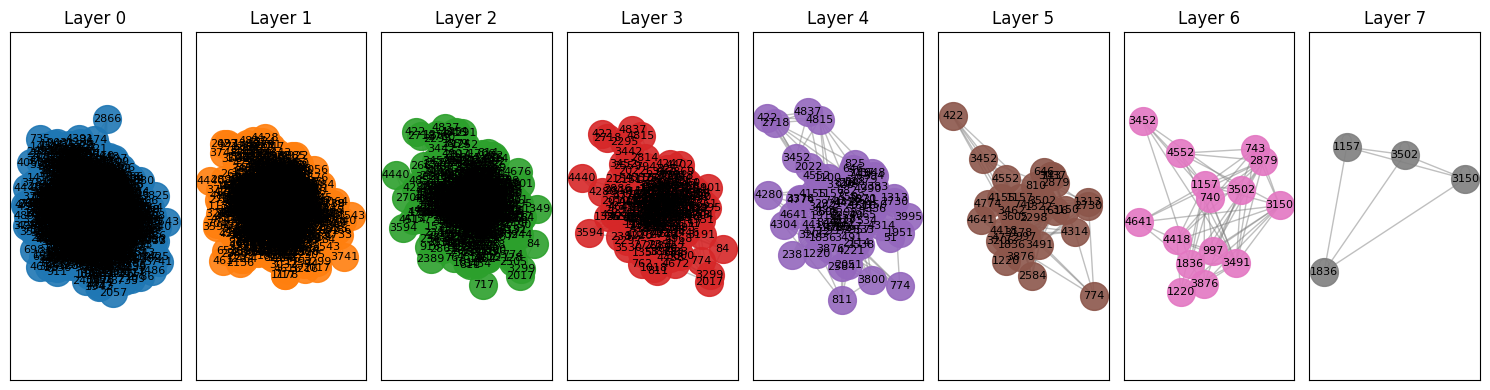

In [46]:
# here we plot all the layers of the graph
plot_hnsw_layers(hnsw)

In [47]:
import copy

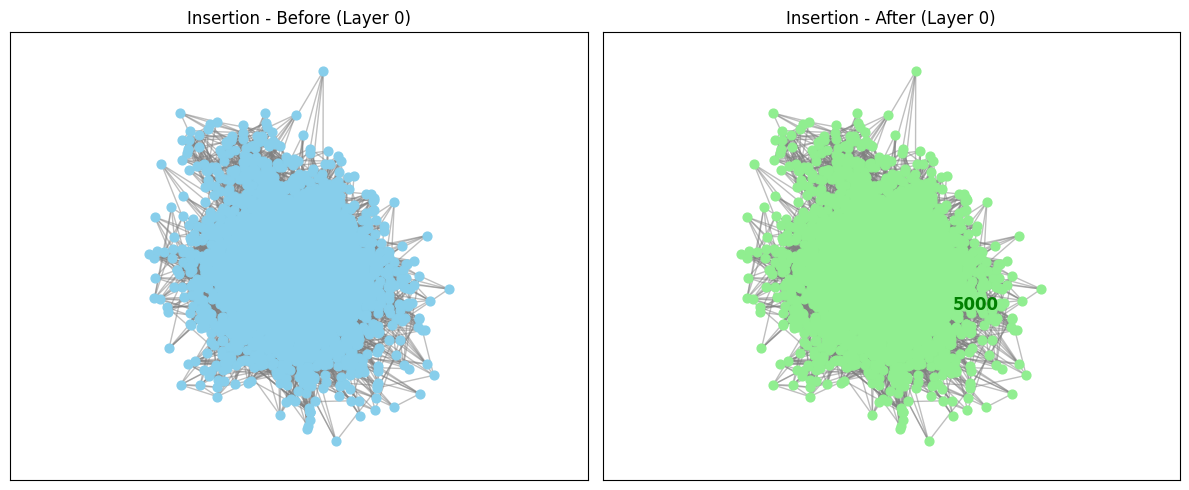

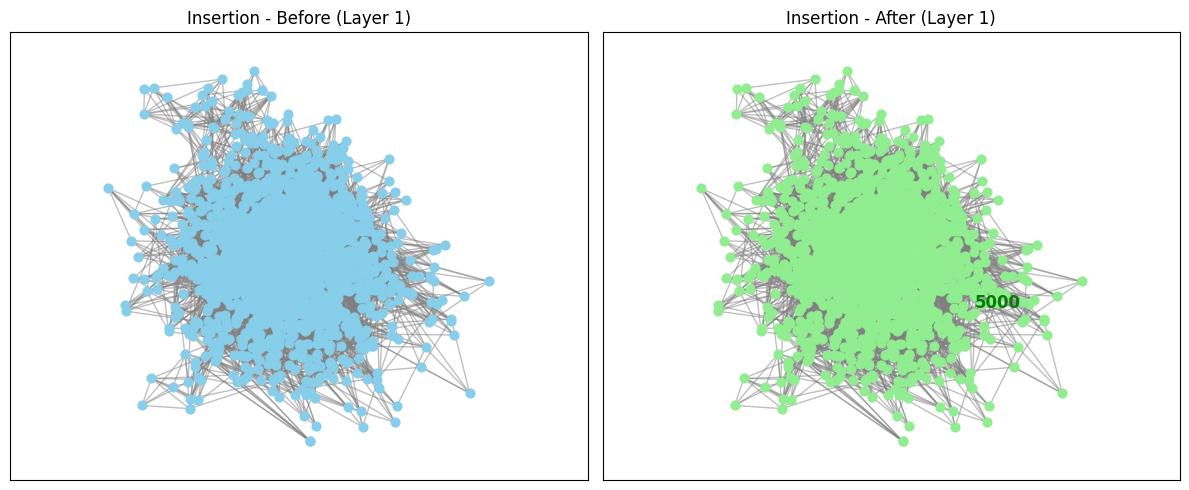

In [48]:
# store the graph state before inserting and compre the two graphs and locate the newly added node.
hnsw_before = copy.deepcopy(hnsw)
new_node_id = hnsw.insert(new_emb)
plot_layers_side_by_side(hnsw_before, hnsw, changed_nodes={new_node_id}, operation_name="Insertion")

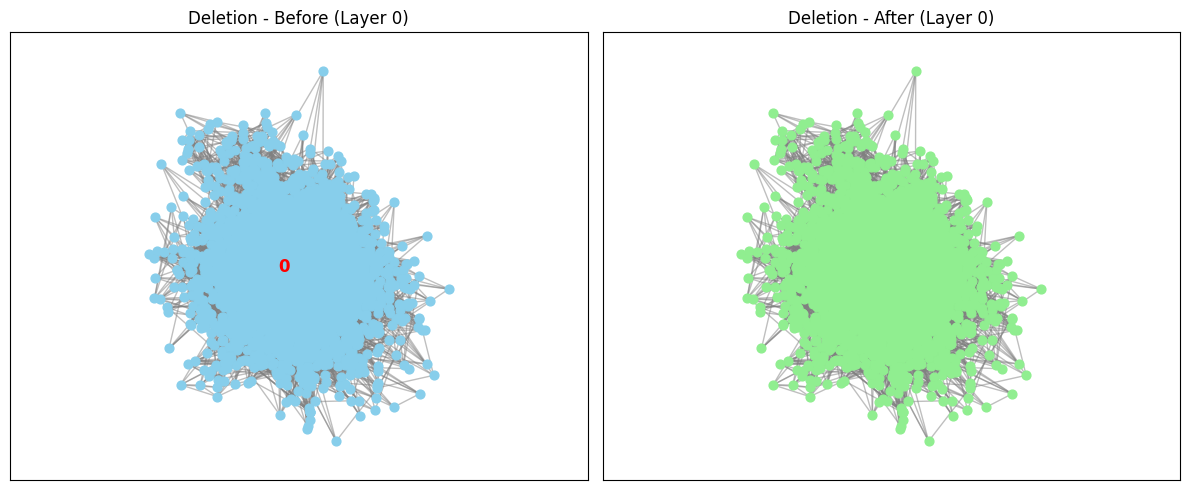

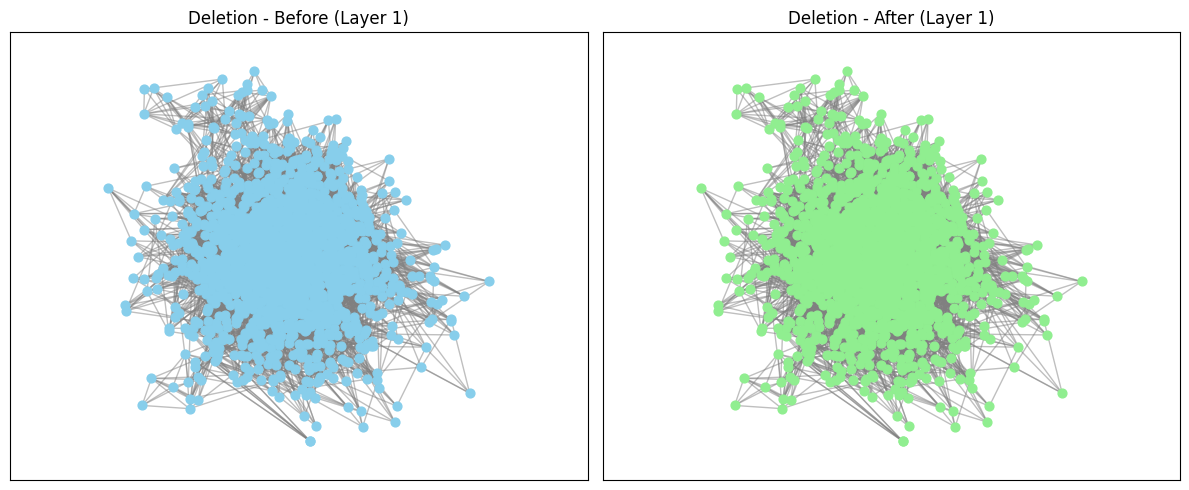

In [49]:
# store the graph state before deleting and compre the two graphs to find the deleted node missing
hnsw_before_del = copy.deepcopy(hnsw)
hnsw.delete(0)
plot_layers_side_by_side(hnsw_before, hnsw, changed_nodes={0}, operation_name="Deletion")

### Questions for you

- **Layer assignment strategy:**  
  How are levels assigned to each node under this exponential scheme?  Is a node assigned to just one layer, or multiple layers? Explain the exact assignment scheme.
  What are the advantages and disadvantages of this method compared to deterministic or uniform assignments?  

- **Computational and memory bottlenecks:**  
  Where do the main costs arise (construction, traversal, updates)?  
  At which stages are these bottlenecks reduced or avoided?  
  Why is this hierarchical design favored over a single flat graph?  



## Part 3: Scalable Retrieval with FAISS

Now that you’ve built your own HNSW structure, it’s time to see how it compares to industry-strength libraries. FAISS (Facebook AI Similarity Search) is a widely used toolkit for nearest neighbor retrieval at scale. In this part, you will explore FAISS’s **built-in indexing methods** and evaluate how they differ from your own implementation.

1. **Indexing Approaches**

   * **Flat Index (Exact Search):**

     ```python
     import faiss
     d = embeddings.shape[1]   # embedding dimension
     index_flat = faiss.IndexFlatL2(d)   # exact search
     index_flat.add(embeddings)          # add all vectors
     D, I = index_flat.search(embeddings[:5], k=5)  # search first 5 queries
     ```

   * **HNSW Index (Approximate Search):**

     ```python
     index_hnsw = faiss.IndexHNSWFlat(d, 32)  # 32 = max neighbors per node
     index_hnsw.hnsw.efConstruction = 40      # build-time parameter
     index_hnsw.add(embeddings)
     D_hnsw, I_hnsw = index_hnsw.search(embeddings[:5], k=5)
     ```

2. **Comparison**

   * **Computation:** How does query speed change between the flat index and FAISS HNSW as the dataset size grows?
   * **Memory:** How much extra memory is used to store the graph structure in FAISS HNSW compared to the flat index?
   * **Quality:** How close are the retrieved neighbors from FAISS HNSW to the ground-truth neighbors found by exact search? (Measurectly measure the speed difference?
and recommendation)?


In [54]:
!pip install faiss-cpu

In [59]:
import faiss

In [60]:
# Flat Index (Exact Search)
def flat_index_search(embeddings, query_emb, k=5):
    d = embeddings.shape[1]  # embedding dimension
    index_flat = faiss.IndexFlatL2(d)
    index_flat.add(embeddings)
    D, I = index_flat.search(query_emb[None, :], k)
    return D, I

In [61]:
def hnsw_index_search(embeddings, query_emb, k=5):
    d = embeddings.shape[1]
    index_hnsw = faiss.IndexHNSWFlat(d, 32)  # 32 = max neighbors per node
    index_hnsw.hnsw.efConstruction = 40
    index_hnsw.add(embeddings)
    D_hnsw, I_hnsw = index_hnsw.search(query_emb[None, :], k)
    return D_hnsw, I_hnsw


In [62]:
# Profile Flat Index
D_flat, I_flat = profile(flat_index_search, 'Flat Index Search', sliced_embeddings, query_emb)
print("Flat Index Top 5 Results:")
for idx in I_flat[0]:
    print(titles[idx])


profile Flat Index Search
Flat Index Search took 0.0177s, memory peak 14.93 MB
Flat Index Top 5 Results:
The Atlantic Monthly, Volume 09, No. 55, May, 1862 by Various
The Story of Geographical Discovery: How the World Became Known by Joseph Jacobs
The Atlantic Monthly, Volume 02, No. 12, October, 1858 by Various
Deadly Pollen by Stephen Oliver
Unmanned by Stephen Oliver


In [63]:
# Profile HNSW Index
D_hnsw, I_hnsw = profile(hnsw_index_search, 'HNSW Index Search', sliced_embeddings, query_emb)
print("\nHNSW Index Top 5 Results:")
for idx in I_hnsw[0]:
    print(titles[idx])

profile HNSW Index Search
HNSW Index Search took 0.5642s, memory peak 0.00 MB

HNSW Index Top 5 Results:
The Atlantic Monthly, Volume 09, No. 55, May, 1862 by Various
The Atlantic Monthly, Volume 02, No. 12, October, 1858 by Various
Deadly Pollen by Stephen Oliver
Unmanned by Stephen Oliver
Scorched Earth: A Future History of Planet Earth by Walter D. Petrovic


In [64]:
# hwere we do a computation to measure query speed for different dataset sizes
def measure_speed(embeddings, query_emb, sizes=[100, 500, 1000]):
    flat_times = []
    hnsw_times = []
    for size in sizes:
        sub_emb = embeddings[:size]

        # Flat Index
        t0 = time.perf_counter()
        d = sub_emb.shape[1]
        index_flat = faiss.IndexFlatL2(d)
        index_flat.add(sub_emb)
        index_flat.search(query_emb[None, :], k=5)
        flat_times.append(time.perf_counter() - t0)

        # HNSW Index
        t0 = time.perf_counter()
        index_hnsw = faiss.IndexHNSWFlat(d, 32)
        index_hnsw.hnsw.efConstruction = 40
        index_hnsw.add(sub_emb)
        index_hnsw.search(query_emb[None, :], k=5)
        hnsw_times.append(time.perf_counter() - t0)

    # Create a DataFrame for results
    results = pd.DataFrame({
        'Dataset Size': sizes,
        'Flat Index Time (s)': flat_times,
        'HNSW Index Time (s)': hnsw_times
    })
    print("\nSpeed Comparison:")
    print(results)
    return sizes, flat_times, hnsw_times

In [65]:
# hwere we compute memory to estimate memory usage
def measure_memory(embeddings):
    d = embeddings.shape[1]

    # Flat Index
    tracemalloc.start()
    index_flat = faiss.IndexFlatL2(d)
    index_flat.add(embeddings)
    _, peak_flat = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # HNSW Index
    tracemalloc.start()
    index_hnsw = faiss.IndexHNSWFlat(d, 32)
    index_hnsw.hnsw.efConstruction = 40
    index_hnsw.add(embeddings)
    _, peak_hnsw = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    print("\nMemory Usage:")
    print(f"Flat Index Peak Memory: {peak_flat / 1e6:.2f} MB")
    print(f"HNSW Index Peak Memory: {peak_hnsw / 1e6:.2f} MB")
    return peak_flat / 1e6, peak_hnsw / 1e6

In [66]:
# here we check the quality to compare retrieved neighbors
def measure_quality(I_flat, I_hnsw, k=5):
    flat_set = set(I_flat[0])
    hnsw_set = set(I_hnsw[0])
    precision = len(flat_set.intersection(hnsw_set)) / k
    print(f"\nQuality (Precision@k={k}): {precision:.2f}")
    return precision

In [67]:
# Run comparisons
sizes, flat_times, hnsw_times = measure_speed(embeddings, query_emb)
peak_flat, peak_hnsw = measure_memory(embeddings)
precision = measure_quality(I_flat, I_hnsw)


Speed Comparison:
   Dataset Size  Flat Index Time (s)  HNSW Index Time (s)
0           100             0.000756             0.006462
1           500             0.000606             0.038062
2          1000             0.000947             0.081324

Memory Usage:
Flat Index Peak Memory: 0.00 MB
HNSW Index Peak Memory: 0.00 MB

Quality (Precision@k=5): 0.80


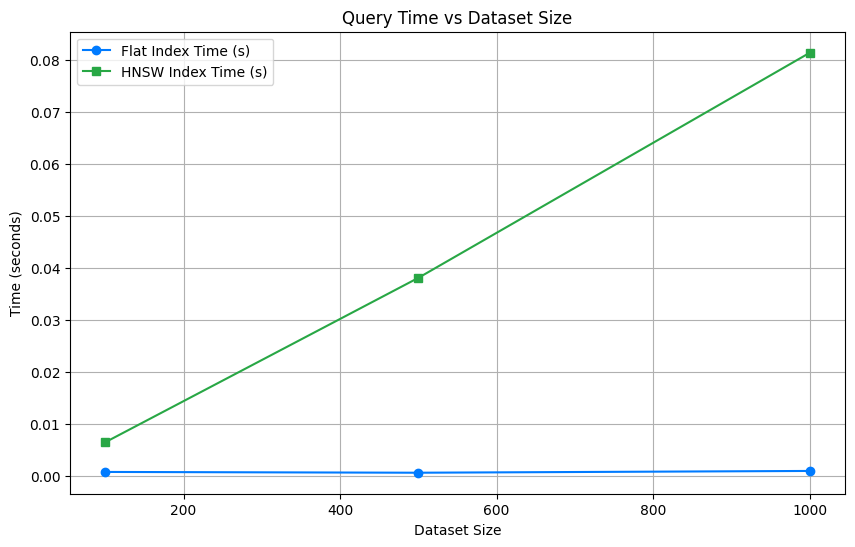

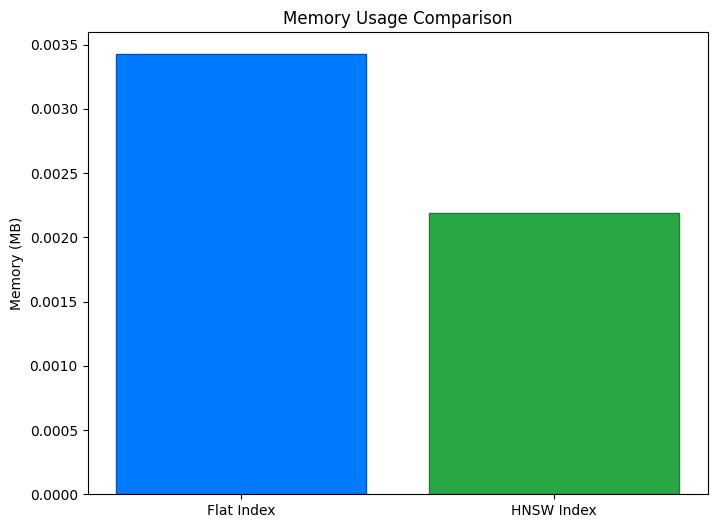


Summary Table:
          Metric  Value
0  Precision@k=5    0.8


In [68]:
# Line Plot for Query Time vs Dataset Size
plt.figure(figsize=(10, 6))
plt.plot(sizes, flat_times, marker='o', color='#007bff', label='Flat Index Time (s)')
plt.plot(sizes, hnsw_times, marker='s', color='#28a745', label='HNSW Index Time (s)')
plt.xlabel('Dataset Size')
plt.ylabel('Time (seconds)')
plt.title('Query Time vs Dataset Size')
plt.legend()
plt.grid(True)
plt.show()

# Bar Plot for Memory Usage
plt.figure(figsize=(8, 6))
labels = ['Flat Index', 'HNSW Index']
memory_usage = [peak_flat, peak_hnsw]
colors = ['#007bff', '#28a745']
plt.bar(labels, memory_usage, color=colors, edgecolor=['#0056b3', '#1e7e34'])
plt.ylabel('Memory (MB)')
plt.title('Memory Usage Comparison')
plt.show()

# Summary Table for Quality
print("\nSummary Table:")
summary = pd.DataFrame({
    'Metric': ['Precision@k=5'],
    'Value': [precision]
})
print(summary)